<a href="https://colab.research.google.com/github/noah-beniteznelson/recharge_deficit/blob/main/PART_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- [![DOI](https://zenodo.org/badge/357586333.svg)](https://zenodo.org/badge/latestdoi/357586333) -->

Change DOI HERE

#**PART I**

Part I of code for *Unsaturated zone water storage regulates recharge to groundwater and subsequent runoff response in seasonally dry California basins*.

---


**Authenticate Google Earth Engine (GEE) account and connect to project.** First time users sign-up [here](https://earthengine.google.com/new_signup/).

In [1]:
import ee
ee.Authenticate() # Trigger the authentication flow.
ee.Initialize(project='rempe-hydro') # Initialize the library.

**Load GEE assets.**  Learn more about accessing GEE products using Python [here](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api).

In [2]:
prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81d")
pml = ee.ImageCollection("CAS/IGSNRR/PML/V2_v017")
USGS_landcover = ee.Image('USGS/NLCD_RELEASES/2019_REL/NLCD/2019')

# Derived from gNATSGO (Soil Survey Staff, 2019):
densic = ee.Image('users/ericamccormick/20_RockMoisture/products/gNATSGO/densic_weavg_lower_reprojected')
paralithic = ee.Image('users/ericamccormick/20_RockMoisture/products/gNATSGO/paralithic_weavg_lower_reprojected')
lithic = ee.Image("users/ericaelmstead/20_RockMoisture/gNATSGO/lithic_weavg_lower_reprojected")

**Mount Google Drive and create folder to save project.** For running analyses in GoogleColab, save and  import datasets to/from selected folder in Google Drive.  By default, files are saved to created "recharge_defcit" folder.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

# Create folder to save project
import os
from os import path
if path.exists('/content/drive/My Drive/recharge_deficit') == False:
  os.mkdir('/content/drive/My Drive/recharge_deficit')

Mounted at /content/drive/


**Load packages.**

In [ ]:
!pip install geemap
import geemap

In [5]:
!pip install -q geopandas
import geopandas as gpd

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy
import datetime
import requests
import json
import urllib
import warnings

from datetime import timedelta
from shapely.geometry import Polygon

from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from matplotlib.collections import LineCollection
matplotlib_axes_logger.setLevel('ERROR')

from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import r2_score
%config InlineBackend.figure_format = 'retina'

#**1. Extract catchment hydrology**

Extract daily discharge ($Q$, L/T), precipitation ($P$, L/T), and evapotranspiration ($ET$, L/T) from selected undisturbed U.S. Geological Survey (USGS) gauged catchments identified in Hahm *et al.* (2019).  

---

**Define helper functions for extracting watershed hydrology.**

In [7]:
def extract_geometry(gage):
  """Retrieves the watershed basin geometry from the U.S. Geological Survey
  (USGS) National Water Information System as a Google Earth Engine (GEE)
  feature and GeoPandas GeoDataFrame.
  ----------
  Parameters
  ----------
  gage (:obj:`str`): USGS 8-number gage station ID

  ----------
  Returns
  ----------
  basin_poly (:obj:`feature`):  GEE polygon of basin.
  basin_geom (:obj:`gdf`):   GeoPandas GeoDataFrame containing the basin's geometry.
  """
  basin_geom = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)

  # Check for MultiPolygon and simplify watershed bounds as needed
  if basin_geom.geometry[0].geom_type == 'MultiPolygon':
    print('\tMultiPolygon found, simplifying watershed boundary for gage '+gage)
    basin_geom = gpd.GeoDataFrame(geometry=gpd.GeoSeries(basin_geom.convex_hull))
  poly_coords = [item for item in basin_geom.geometry[0].exterior.coords]
  basin_poly = ee.Geometry.Polygon(coords=poly_coords)
  return basin_poly, basin_geom


def getFlow(gage, basin_geom, start_date, end_date):
  """Retrieves daily discharge measured by U.S. Geological Survey (USGS) gage
  stations from the National Water Information System between selected dates.
  ----------
  Parameters
  ----------
  gage (:obj:`str`): USGS 8-number gage station ID
  basin_geom (:obj:`gdf`):   GeoPandas GeoDataFrame containing the basin's geometry.
  start_date (:obj:`str`): Start of data retrieval (format: 'yyyy-mm-dd')
  end_date (:obj:`str`): End of data retrieval (format: 'yyyy-mm-dd')
  ----------
  Returns
  ----------
  df (:obj:`df`):    Discharge (mm/day)
  """
  # Read streamflow data and clean csv
  url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=%s&referred_module=sw&period=&begin_date=%s&end_date=%s'%(gage, start_date, end_date)
  df = pd.read_csv(url, header=31, delim_whitespace=True)
  df.columns = ['usgs', 'site_number', 'datetime', 'Q_cfs', 'a']
  df.index = pd.to_datetime(df.datetime)

  # Convert discharge from cfs to mm/day using drainage area
  area_mm2 = basin_geom.to_crs('epsg:26910').geometry[0].area*1e6
  df['q'] = 2.44657555e12*pd.to_numeric(df['Q_cfs'], errors='coerce')/area_mm2 # Flow in mm/day
  df = df[['q']].astype(float, errors='ignore')
  df.columns = ['q']
  return df


def image_collection_to_df(collection,band,geom,start_date='1985-01-01',end_date='2050-01-01',scale=100,band_limit=5000):
  """Includes workaround for new GEE Python API limit on maximum number of bands
  for ee.ImageCollection.toBands() function.
  ----------
  Parameters
  ----------
  collection: GEE ImageCollection
  band (:obj:`str`): Target band for extraction
  geom: GEE polygon defining region
  start_date (:obj:`str`): Start of data retrieval (default='1985-01-01')
  end_date (:obj:`str`): End of data retrieval (default='2050-01-01')
  scale (:obj:`int`): Scale in meters for GEE reducer function (default=100)
  band_limit (:obj:`int`): Limit of ee.ImageCollection.toBands() function (default=5000)
  ----------
  Returns
  ----------
  df (:obj:`df`): Dataframe of band with datetime index
  ----------
  Notes
  ----------
  Data range of PRISM: 1981-01-01 to 2023-10-12 (daily total)
  Data range of PML: 2000-02-26 to 2020-12-26 (8-day average)
  Data range of MODIS: 2001-10-01 to 2023-09-22 (8-day total)
  Data range of OpenET: 2016-01-01 to 2022-12-01 (monthly total)

  """
  size = collection.filter(ee.Filter.date(start_date,end_date)).select(band).size().getInfo()

  # Check if ee.ImageCollection.toBands() function limit exceeded
  if size > band_limit:
    num_chunks = np.ceil(size/band_limit).astype(int)
    date = pd.to_datetime(start_date,format='%Y-%m-%d')

    for i in range(num_chunks):
      start_date = date + timedelta(days=i * band_limit)
      end_date = date + timedelta(days=(i+1) * band_limit - 1)
      asset = collection.filter(ee.Filter.date(start_date,end_date)).select(band).toBands()
      reducer_dict = asset.reduceRegion(reducer=ee.Reducer.mean(), geometry=geom, scale=500, maxPixels=1e12).getInfo()
      chunk = pd.DataFrame(list(reducer_dict.items()),columns=['date', band])
      df = pd.concat([df,chunk], ignore_index=True) if i != 0 else chunk

  # ImageCollection within ee.ImageCollection.toBands() function limits
  else:
    asset = collection.filter(ee.Filter.date(start_date,end_date)).select(band).toBands()
    reducer_dict = asset.reduceRegion(reducer=ee.Reducer.mean(), geometry=geom, scale=scale, maxPixels=1e12).getInfo()
    df = pd.DataFrame(list(reducer_dict.items()),columns=['date', band])

  # Format date column -> comment out if errors appear and assign index later
  df['date'] = [item.replace('-', '_').split('_')[:-1] for item in df['date'].values]
  df['date'] = [pd.to_datetime('-'.join(item[0:3])) for item in df['date'].values]
  df.set_index('date',inplace=True)

  # Format date column for OpenET
  # df['date'] = pd.to_datetime([item.split('_')[1] for item in df['date'].values])
  # df_openet.set_index('date',inplace=True)
  return df

**Extract hydrology.**  

*Warning: The following code block takes ~10-15 minutes to run.*

In [8]:
# Time range for data extraction
start_date = '2000-01-01'
end_date = '2023-01-01'

# List of USGS gage station IDs corresponding to watersheds studied in Hahm et al. (2019)
gage_list = ['11475560', '11475800', '11469000', '11449500', '11379500',
             '11476600', '11172945', '11180900', '11180960', '11180825',
             '11182500', '11299600', '11154700', '11176400', '11151300',
             '11253310', '11134800', '11132500', '11141280', '11284400',
             '11046300', '11200800', '11224500', '11111500', '11046360']

# Hydrology for each gage
for gage in gage_list:
  # Drainage area upstream of USGS gage as GEE polygon and geopandas DataFrame
  basin_poly, basin_geom = extract_geometry(gage)

  # USGS average daily discharge (mm/day)
  q = getFlow(gage, basin_geom, start_date, end_date)

  # PRISM total daily precipitaion (mm/day)
  ppt = image_collection_to_df(prism,'ppt',basin_poly,start_date=start_date,end_date=end_date,scale=100)

  # PML average 8-day evapotranspiration (mm/day) upsampled to daily series
  ec = image_collection_to_df(pml,'Ec',basin_poly,start_date=start_date,end_date=end_date,scale=500)
  ei = image_collection_to_df(pml,'Ei',basin_poly,start_date=start_date,end_date=end_date,scale=500)
  es = image_collection_to_df(pml,'Es',basin_poly,start_date=start_date,end_date=end_date,scale=500)

  pml_et = ec.join([ei,es])
  pml_et['et'] = pml_et[['Ec','Ei','Es']].sum(axis=1)
  # et = pd.DataFrame(pml_et['et'].resample('D').interpolate(method='linear'))
  et = pd.concat([pml_et['et'], pd.Series([0], index=[pml_et.index[0] - np.timedelta64(8,'D')])])
  et = pd.DataFrame(et.resample('D').bfill())
  et.rename(columns={0:'et'},inplace=True)

  # OpenET total monthly evapotranspiration (mm/month) upsampled to daily series
  # openet = ee.ImageCollection("OpenET/ENSEMBLE/CONUS/GRIDMET/MONTHLY/v2_0")
  # openet_et = image_collection_to_df(openet,'et_ensemble_mad',basin_poly,start_date=start_date,end_date=end_date,scale=30)
  # openet_et = pd.concat([openet_et['et_ensemble_mad'], pd.Series([0], index=[openet_et.index[-1] + np.timedelta64(1,'M') + np.timedelta64(1,'D')])]).resample('D').first()
  # openet_et = pd.DataFrame(openet_et.groupby(et.notna().cumsum(),group_keys=False).apply(lambda x: x/len(x.index))).ffill()[:-1]
  # openet_et.rename(columns={0:'openET'},inplace=True)

  # Combine discharge, precipitation, evapotranspiration
  df_gage = q.join([ppt,et],how='outer').add_suffix('_%s'%gage)
  df_gages = df_gage if gage==gage_list[0] else df_gages.join(df_gage,how='outer')
  print('Successfully extracted hydrology upstream of gage %s.'%(gage))

# Add date, wateryear column
df_gages['wateryear'] = np.where(df_gages.index.month<10, df_gages.index.year, df_gages.index.year+1)
df_gages['date'] = df_gages.index

Successfully extracted hydrology upstream of gage 11475560.
Successfully extracted hydrology upstream of gage 11475800.
Successfully extracted hydrology upstream of gage 11469000.
Successfully extracted hydrology upstream of gage 11449500.
Successfully extracted hydrology upstream of gage 11379500.
Successfully extracted hydrology upstream of gage 11476600.
Successfully extracted hydrology upstream of gage 11172945.
Successfully extracted hydrology upstream of gage 11180900.
Successfully extracted hydrology upstream of gage 11180960.
Successfully extracted hydrology upstream of gage 11180825.
Successfully extracted hydrology upstream of gage 11182500.
Successfully extracted hydrology upstream of gage 11299600.
Successfully extracted hydrology upstream of gage 11154700.
Successfully extracted hydrology upstream of gage 11176400.
Successfully extracted hydrology upstream of gage 11151300.
Successfully extracted hydrology upstream of gage 11253310.
Successfully extracted hydrology upstrea

**Save extracted data to Google Drive.** Select file name, type (default: csv), and location in Drive

In [9]:
# Helper function to check if path already exists before saving DataFrame
def check_path_write(df,filename,path):
  path = path+filename
  if os.path.exists(path)!=True:
    df.to_csv(path)

path = "/content/drive/My Drive/recharge_deficit/" # change path here
filename = "extracted_catchment_data.csv" # change filename here
check_path_write(df_gages,filename,path)

#**2. Clean data, initial catchment filter**
Identify and exclude days without complete flux data from analysis for each catchment. Identify catchments with at least 10 complete years of data ($\geq$ 360 days).

**If section 1 has already previously been run, mount Google Drive, load packages, and start here.**

**Load data.**  Load extracted catchment data from Google Drive and results of Hahm et al. (2019) analysis from Github.

In [10]:
# Extracted catchment data
path = '/content/drive/My Drive/recharge_deficit/'
filename = "extracted_catchment_data.csv"  #_new_method
df_gages = pd.read_csv(path + filename)
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)

**Clean data, filter catchments.**

In [11]:
# Unique gage IDs in DataFrame
gage_list = [sub.replace('ppt_', '') for sub in [k for k in df_gages.columns.tolist() if 'ppt' in k]]

for gage in gage_list:
  # Remove days with missing data
  df_gage = df_gages.filter(regex=".*%s"%gage)
  df_gage = df_gage.dropna()

  # Remove catchments with less than 10 complete years of data
  df_gage.loc[:,'year'] = df_gage.index.year
  days = df_gage.groupby('year').size()
  if len(days[days>=360]) < 10:
    continue

  # Join to filtered DataFrame
  df_gage = df_gage.filter(regex=".*%s"%gage)
  df_filt = df_gage if gage == gage_list[0] else df_filt.join(df_gage,how='outer')

# Append date and wateryear column
df_filt.loc[:,'wateryear'] = np.where(df_filt.index.month<10, df_filt.index.year, df_filt.index.year+1)
df_filt.loc[:,'date'] = df_filt.index

# New gage list
gage_list = [sub.replace('ppt_', '') for sub in [k for k in df_filt.columns.tolist() if 'ppt' in k]]

#**3. Calculate the root-zone storage deficit, $D$**

 Following McCormick *et al.* (2021) and Dralle *et al.* (2020).

**Define function.**

In [12]:
def deficit(df):
  """Calculate D(t) after McCormick et al., 2021 and Dralle et al., 2020.

  Parameters
  ----------
  df (:obj:`df`): DataFrame with date ('date'), water year ('wateryear'),
  precipitation ('ppt', mm), and evapotranspiration ('et', mm) columns
  ----------
  Returns
  ----------
  df (:obj:`df`): DataFrame containing deficit ('D', mm) and wateryear deficit is ('D_wy', mm).
  """
  # Check to make sure everything we need is here
  necessary_columns = ['date', 'et', 'ppt', 'wateryear']
  for col in necessary_columns:
    if col not in df:
      print('WARNING: %s missing. Deficit cannot be calculated. Check assets specified in layers.'%col)
      return
  df_deficit = df.reset_index(drop=True).copy()

  # Calculate A and D
  df_deficit['A'] = df_deficit['et'].subtract(df_deficit['ppt'])
  df_deficit['D'] = 0
  for _i in range(df_deficit.shape[0]-1):
    df_deficit.loc[_i+1, 'D'] = max((df_deficit.loc[_i+1, 'A'] + df_deficit.loc[_i, 'D']),0)

  # Calculate wateryear deficit and merge columns with dataframe
  df_deficit_wy = pd.DataFrame()
  for wy in df_deficit.wateryear.unique():
    temp = df_deficit[df_deficit['wateryear'] == wy][['date','et','ppt']]
    temp['A'] = temp['et'].subtract(temp['ppt'])
    temp['D_wy'] = 0
    temp = temp.reset_index()
    for _i in range(temp.shape[0]-1):
      temp.loc[_i+1, 'D_wy'] = max((temp.loc[_i+1, 'A'] + temp.loc[_i, 'D_wy']), 0)
    df_deficit_wy = pd.concat([df_deficit_wy, temp])
  df_deficit_wy = df_deficit_wy[['date','D_wy']]
  df_deficit = df_deficit.merge(df_deficit_wy, how = 'left', on = 'date')
  df_deficit.index=pd.to_datetime(df_deficit['date'])
  return df_deficit[['D','D_wy']]

**Calculate deficit.**  Append to DataFrame.  (75 sec)

In [13]:
# New DataFrame for deficit, water year deficit
df_deficit = pd.DataFrame(index=df_gages.index)

for gage in gage_list:
  # Define gage data
  df_gage = df_filt.filter(regex=".*%s"%gage).join(df_filt[['date','wateryear']],how='outer').dropna()
  df_gage.columns = df_gage.columns.str.rstrip('_'+gage)
  # Calculate deficit, water year deficit
  df_deficit = df_deficit.join(deficit(df_gage).add_suffix('_'+gage))

# Join deficit DataFrame to cleaned DataFrame
df_filt_deficit = df_filt.join(df_deficit)

<ipython-input-12-00c7f7f61e91>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['A'] = temp['et'].subtract(temp['ppt'])


#**4. Calculate recharge, $R$, after deriving the sensitivity function, $g(Q)$**
Derive the sensitivity function presented in Wlostowski et al. (2020).  Estimate $dQ/dt$ following Palmroth *et al.* (2010) and Dralle *et al.* (2018), using the variable time step method of Rupp & Selker (2006).
 Calculate recharge following Dralle *et al.* (2023).

Fit sensitivity function on recessions with a 1-day buffer between the start and end of the recession to avoid the impact of recharge from prior and subsequent storm events on recession behavior.

**Define functions.**

In [14]:
# Kirchner (2009) binning function
def KirchnerBinning(df, binning, min_per_bin=10, loud=False):
  df = df.sort_values('q',ascending=False)
  logQ = np.array(np.log(df.q))
  logRange = np.max(logQ) - np.min(logQ)
  minBinSize = logRange*.01
  binBoundaries = [0]
  for i in range(1,len(df)):
      if abs(logQ[i] - logQ[binBoundaries[-1]]) < minBinSize:
          if loud: print('Bin too small')
          continue
      if abs(i-binBoundaries[-1]) < min_per_bin:
          if loud: print('Not enough data points')
          continue
      curr = df.loc[binBoundaries[-1]:i,binning]
      if np.std(-curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(-curr)/2:
          if loud: print('Bin too heterogeneous')
          continue
      binBoundaries.append(i)
  return binBoundaries

# Function to derive the sensitivity function and calulate recharge
def calc_recharge(df,gage,ax,title=None,labels=[]):
  """Calculate and returns recharge for catchment using DataFrame of hydrologic
  values.  Plot log(dQ/dt) vs. log(Q) on specified axis object. Optional
  averaging is not recommended and set to 'None' by default.
  ----------
  Parameters
  ----------
  df (:obj:`df`): DataFrame containing catchment hydrology
  gage (:obj:`str`): USGS 8-number gage station ID
  ax (:obj:`axes`): Matplotlib axes object for plotting
  title (:obj:`str`): Optional title for plot
  labels (:obj:'str') : Axis labels are not shown when labels = 'None'
  ----------
  Returns
  ----------
  df_recharge (:obj:`df`):   DataFrame containing recharge [mm]
  """
  # Redefine gage data
  df_gage = df.filter(regex=".*%s"%gage).join(df[['date','wateryear']],how='outer')
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index=pd.to_datetime(df_gage.index)

  # Long-term discharge mean over all available data from analysis months (November-March)
  df_winter = df_gage[df_gage.index.month.isin([11,12,1,2,3])]
  meanQ = np.mean(df_winter.q)

  # Create lists to store discharge (qs) and its derivative (dqs)
  mean_fraction = 0.001 # mm/day
  lag = 1 # days
  qs = []
  dqs = []

  # Iterate through water year winter streamflow recessions
  for wateryear,group in df_winter.groupby('wateryear'):
    group = group.dropna(subset='q')
    if len(group) < 100:
      continue
    runoff = np.array(group.q)
    dq = np.diff(runoff)
    # Find recession periods (index of start and stop)
    idx = np.where(dq<0)[0]
    groups = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
    if len(groups)>1:
      periods = [[group[0], group[-1]] for group in groups]
    else:
      continue
    # Calculate dq/dt
    for recession in periods:
      start = recession[0]+1 # Originally no buffer
      stop = recession[1]
      # Check for recessions > 1 day
      if (stop-start)<1: # Originally == 0
        continue
      for i in range(start, stop):
        q_diffs = runoff[start] - runoff[i+1:stop]
        idx_end = np.where(q_diffs>mean_fraction*meanQ)[0]
        if len(idx_end)>0:
          idx_end = idx_end[0]
          qs.append((runoff[i] + runoff[i+idx_end+1])/2)
          dqs.append((runoff[i+idx_end+1]-runoff[i])/(idx_end+1))
        else:
          continue

  # Append to list
  qs = np.array(qs)
  dqs = np.array(dqs)

  # Plot raw data
  ax.scatter(np.log(qs), np.log(-dqs), label="raw", s=1, color='lightgray', zorder=-2)

  # Sort qs and eps in descending order and calculate bin boundaries using Kirchner binning
  df_kirchner = pd.DataFrame({'q':qs, 'dq':dqs})
  df_kirchner = df_kirchner.sort_values('q',ascending=False)
  binBoundaries = KirchnerBinning(df_kirchner, binning='dq', min_per_bin=10)

  # Calculate mean discharge, mean adjusted recession rate, and standard errors for each bin
  qs = np.array([np.mean(df_kirchner.q[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  dqs = np.array([np.mean(df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
  sigmas = np.array([np.std(np.log(-df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]].loc[df_kirchner.dq[binBoundaries[i]:binBoundaries[i+1]]<0]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12

  # # Remove bins with infinitely small (~0) standard error
  error_idx = sorted([i for i in range(len(sigmas)) if sigmas[i] < 1e-2], reverse=True)
  qs = np.delete(qs,error_idx)
  dqs = np.delete(dqs,error_idx)
  sigmas = np.delete(sigmas,error_idx)

  # Create a scatter plot of log(qs) and log(-dq) with error bars, fitted line
  ax.errorbar(np.log(qs), np.log(-dqs), label="binned", yerr=sigmas, fmt='o', capsize=2, **{'ms':3, 'mfc':'limegreen','zorder':-1})

  # Wlowtoski et al. (2020) sensitivity function
  logqbar = np.log(np.mean(qs))
  logsigma = np.log(np.std(qs))
  def bQ(q,bl,bu):
    return bl + (bu - bl)*0.5*(1 + scipy.special.erf((np.log(q) - logqbar))/(logsigma*np.sqrt(2)))
  def logeps(q,bl,bu,a): # Log transformation
    return np.log(a) + bQ(q,bl,bu)*np.log(q/np.mean(q))
  def eps(q,bl,bu,a):
    qbar = np.exp(logqbar)
    return a*(q/qbar)**bQ(q,bl,bu)
  def g(q,p):
    return eps(q, *p)/q

  # Fit dynamic power function with log transformation
  popt, pcov = curve_fit(logeps, qs, np.log(-dqs), sigma=sigmas**2, maxfev=2000)
  coefficient_of_determination = r2_score(np.log(-dqs), logeps(qs, *popt))
  ax.plot(np.log(qs), logeps(qs, *popt), label=r"$\mathrm{R^2}$ = %.2f"%coefficient_of_determination, lw=2, zorder=-1)

  # Axis labels, title
  if labels != None:
    ax.set(xlabel='ln(Q) [mm/day]', ylabel=r'$\ln(\frac{dQ}{dt})$ [mm/day$^2$]')
  if title!=None:
    ax.set_title(title,fontsize=11,loc='left')

  # Add legend, change order of items
  handles, labels = ax.get_legend_handles_labels()
  order = [1,2,0]
  legend = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize=8, loc='upper left')
  # legend.set_frame_on(False)
  legend.legend_handles[2]._sizes =[6]

  ## Calculate recharge following Dralle et al. (2023)
  # Create a new DataFrame to store recharge
  df_recharge = pd.DataFrame(columns = ['rt_%s'%gage])

  # Iterate through water years and calculate recharge for each year
  for wateryear, group in df_gage.groupby('wateryear'):
    # Temporary DataFrame to store recharge in loop
    df_temp = pd.DataFrame()
    # Calculate direct storage (recharge), assuming 0 at start of wet season
    qvar = group.q.tolist()
    rts = [0]
    for i in range(1,len(qvar)):
      dt = 1.0
      qi = qvar[i]
      qi1 = qvar[i-1]
      # Check for no-flow condition
      rt = 0 if qi == 0 or qi1 == 0 else (qi - qi1)/dt/((g(qi,popt) + g(qi1,popt))/2) + (qi+qi1)/2
      rts.append(rt)

    rts = np.array(rts)
    rts[rts<0] = 0

    # Skip wateryears missing 10% of data
    df_temp['rt_%s'%gage] = rts if len(group) > 324 else np.full(len(group),np.nan)
    df_recharge = pd.concat([df_recharge,df_temp])

  # Assign index to recharge DataFrame
  df_recharge['rt_%s'%gage] = df_recharge['rt_%s'%gage].astype(float)
  df_recharge['date'] = df_gage.index
  df_recharge.set_index('date',inplace=True)
  return df_recharge

**Derive the sensitivity function and calculate recharge for each catchment.**  Plot log(-$dQ/dt$) vs. log($Q$).

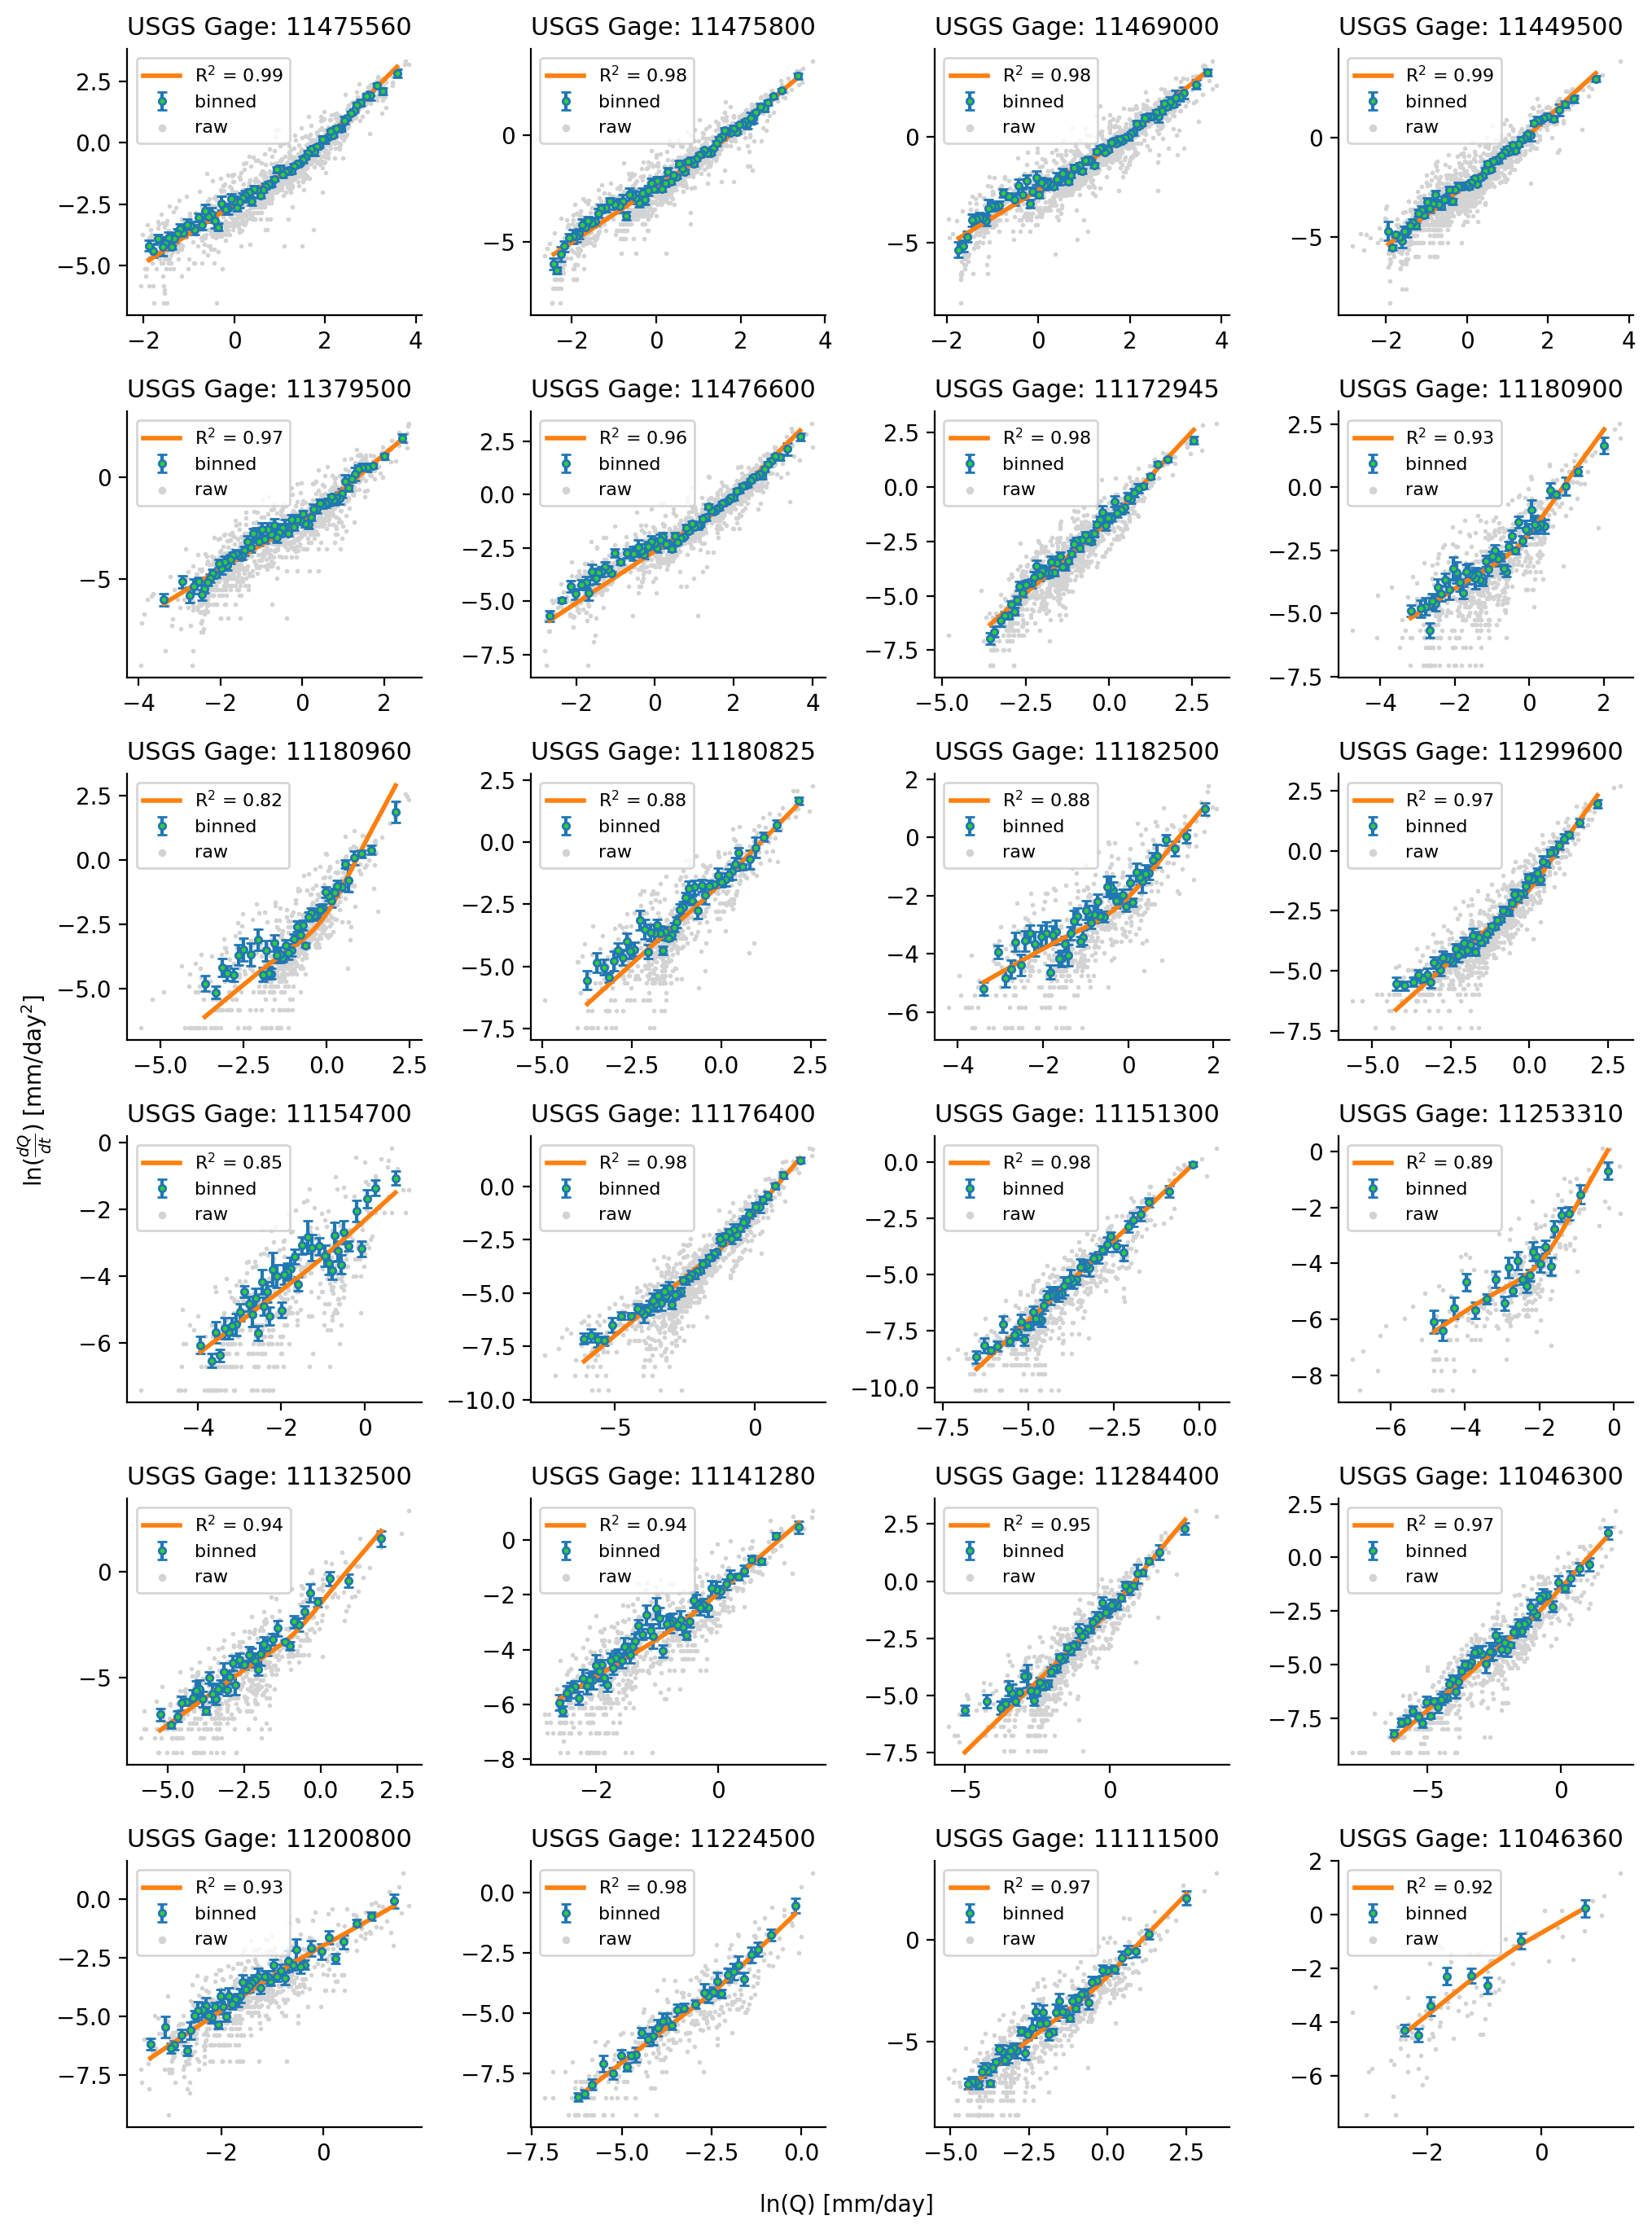

In [15]:
# Supress polyfit rank warning
warnings.simplefilter('ignore', RuntimeWarning)

# New DataFrame for recharge
df_recharge = pd.DataFrame(index=df_gages.index)

# Plotting space
fig, axs = plt.subplots(6,4,figsize=(10,13.5))

# Calculate recharge and append to DataFrame for each catchment, plot sensitivity function
for gage, ax in zip(gage_list,axs.ravel()):
  df_gage_recharge = calc_recharge(df_filt_deficit,gage,ax,title="USGS Gage: %s"%gage,labels=None)
  df_recharge = df_recharge.join(df_gage_recharge,how='outer')

# Label handling
fig.text(0.5, -0.01, 'ln(Q) [mm/day]', ha='center')
fig.text(-0.01, 0.5, r'$\ln(\frac{dQ}{dt})$ [mm/day$^2$]', va='center', rotation='vertical')

# Adjust plot asthetics
fig.tight_layout()
sns.despine()

# Join recharge DataFrame to cleaned DatFrame
df_filt_deficit_recharge = df_filt_deficit.join(df_recharge)

**Create diagram showing method to calculate recharge.** Show method at Elder Creek (USGS Gage ID: 11475560).

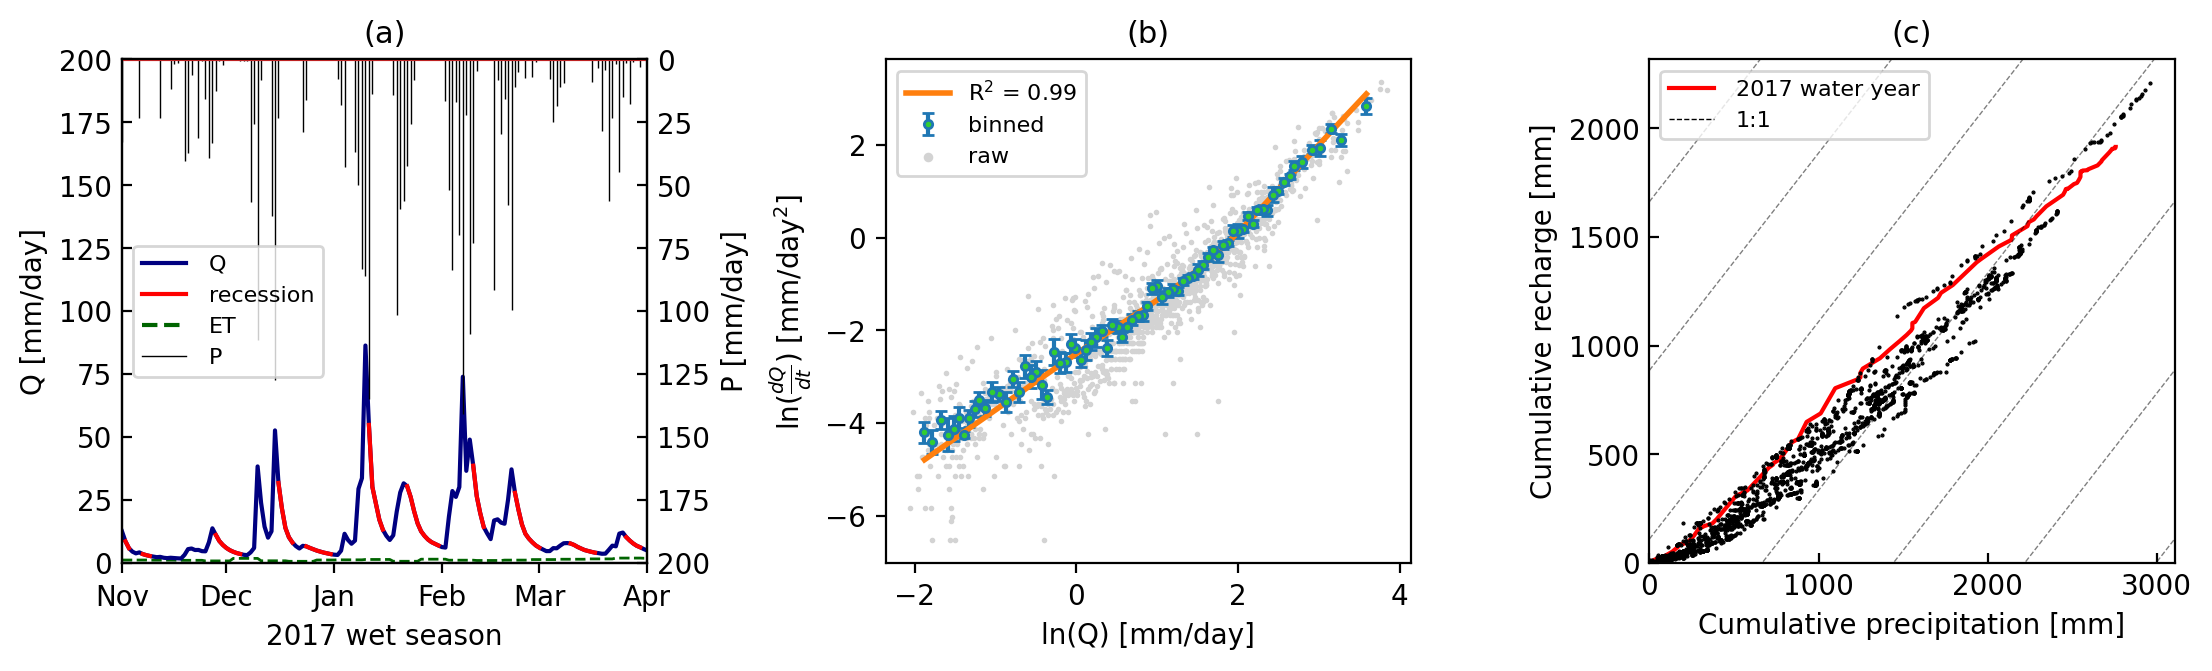

In [16]:
# Define gage data
gage = '11475560'
wateryear=2017
df_gage = df_filt_deficit_recharge.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']],how='outer')
df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
df_gage.set_index('date', inplace=True)
df_gage.index = pd.to_datetime(df_gage.index)

# Plotting space
fig,axs = plt.subplots(1,3,figsize=(11,3.3))

# Winter hydrograph
ax0 = axs[0]
df_winter = df_gage.loc['%s-11-01'%str(wateryear-1):'%s-04-01'%str(wateryear)]
df_winter.plot(y='q', legend=False, color='navy', ax=ax0)
df_winter.plot(y='et', legend=False, color='darkgreen', linewidth=1, ls='--', ax=ax0, zorder=-1)

# Hydrograph recession
datetime = np.array(df_winter.index)
runoff = np.array(df_winter.q)
dq = np.diff(runoff)
# Find recession periods (index of start and stop)
idx = np.where(dq<0)[0]
groups = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
periods = [[group[0], group[-1]] for group in groups]
# Plot
for recession in periods:
  start = recession[0]+1
  stop = recession[1]
  # Check for recessions > 2 days
  if (stop-start)>0:
    ax0.plot(datetime[start:stop], runoff[start:stop], color='red')

# Precipitation
twinx = ax0.twinx()
stem = twinx.stem(df_winter.index, df_winter.ppt, 'k', markerfmt='')
plt.setp(stem[1], 'linewidth', 0.5)
plt.setp(stem[1], 'zorder', -2)
twinx.invert_yaxis()

# Sensitivity function
calc_recharge(df_filt_deficit_recharge, gage, ax=axs[1])

# Recharge ramp
ax2 = axs[2]
for wy in set(df_gage.wateryear.to_list()):
  df_winter = df_gage.loc['%s-11-01'%str(wy-1):'%s-04-01'%str(wy)]
  if wy==wateryear:
    df_winter.cumsum().plot(x='ppt', y='rt', color='red', ax=ax2, zorder=1)
  else:
    df_winter.cumsum().plot(x='ppt', y='rt', color='k', style='o', markersize=0.5, ax=ax2)

# 1:1 lines
ymin, ymax = ax2.get_ylim()
xmin, xmax = ax2.get_xlim()
cepts = np.arange(-10*ymax,ymax,max([xmax/4,ymax/4]))
for cept in cepts[:-1]:
  ax2.plot([0,ymax - cept],[cept,ymax],c='k',ls='--',alpha=0.5,lw=0.5)
cept = cepts[-1]
ax2.plot([0,ymax - cept],[cept,ymax],label='1:1',c='k',ls='--',alpha=0.5,lw=0.5)

# Legend handling
Q_line = matplotlib.lines.Line2D([],[],color='navy', label='Q')
recession_line = matplotlib.lines.Line2D([],[],color='red', label='recession')
P_line = matplotlib.lines.Line2D([],[], color='k', lw=0.5, label='P')
ET_line = matplotlib.lines.Line2D([],[],color='darkgreen', ls='--', label='ET')
twinx.legend(handles=[Q_line,recession_line,ET_line,P_line], loc='center left', fontsize='8', handletextpad=1, framealpha=0.8)
wy_line = matplotlib.lines.Line2D([],[],color='red', label='%s water year'%str(wateryear))
equal_line = matplotlib.lines.Line2D([],[],color='k', ls='--', lw=0.5, label='1:1')
ax2.legend(handles=[wy_line,equal_line], loc='upper left', fontsize='8', handletextpad=1)

# Axis handling
ax0.set(xlabel='%s wet season'%str(wateryear), ylabel="Q [mm/day]", ylim=[0,200]) #ylim
ax0.tick_params('y', direction='in')
ax0.minorticks_off()
ax0.tick_params(axis='x', which='major', pad=4)
ax0.xaxis.set_major_locator(mdates.MonthLocator())
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
twinx.set(xlabel='', ylabel='P [mm/day]', ylim=[200,0]) #ylim
twinx.tick_params('y', direction='in')
ax2.set(xlabel="Cumulative precipitation [mm]", ylabel="Cumulative recharge [mm]", xlim=[0,xmax], ylim=[0,ymax])
ax2.tick_params(direction='in')

# Tighten layout, axis titles
axs[0].set_title("(a)",fontsize=11)
axs[1].set_title("(b)",fontsize=11)
axs[2].set_title("(c)",fontsize=11)
fig.tight_layout(pad=0.5)

**Compare recharge to runoff at selected catchments.**  Compare recharge and runoff ramps at Elder Creek (USGS Gage ID 11475560) and Big Creek (11284400).

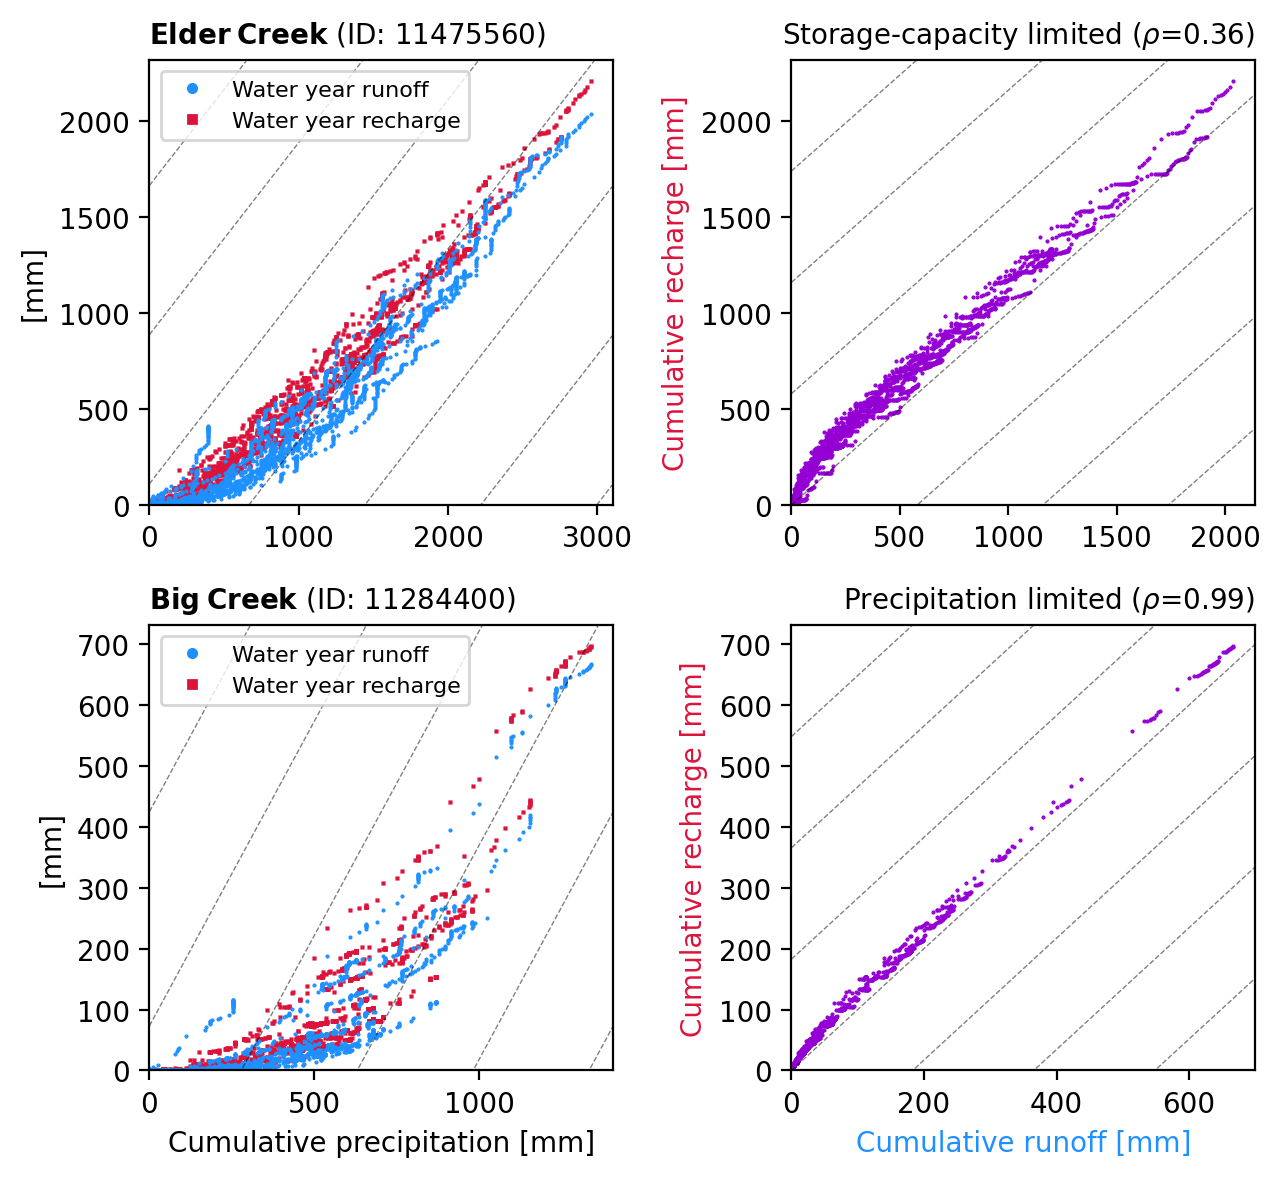

In [17]:
# Short helper function
def extract_gage_data(gage):
  df_gage = df_filt_deficit_recharge.filter(regex=".*%s"%gage).join(df_gages[['date','wateryear']],how='outer')
  df_gage.columns = df_gage.columns.str.rstrip('_%s'%gage)
  df_gage.set_index('date', inplace=True)
  df_gage.index = pd.to_datetime(df_gage.index)
  return df_gage

# Gage data
Elder_ck = '11475560'
Big_ck = '11284400'
df_Elder = extract_gage_data(Elder_ck)
df_Big = extract_gage_data(Big_ck)
gages = [df_Elder,df_Big]

# Plotting space
fig,axs = plt.subplots(2,2,figsize=(6.5,6))

# Plot recharge & runoff ramp
for ax,gage in zip([axs[0,0],axs[1,0]],gages):
  for wy in set(gage.wateryear.to_list()):
    df_winter = gage.loc['%s-11-01'%str(wy-1):'%s-04-01'%str(wy)]
    df_winter.cumsum().plot(x='ppt', y='rt', color='crimson', style='s', legend=False, markersize=0.5, ax=ax, zorder=-1)
    df_winter.cumsum().plot(x='ppt', y='q', color='dodgerblue', style='o', legend=False, markersize=0.5, ax=ax, zorder=0)
  # 1:1 lines
  ymin, ymax = ax.get_ylim()
  xmin, xmax = ax.get_xlim()
  cepts = np.arange(-10*ymax,ymax,max([xmax/4,ymax/4]))
  for cept in cepts[:-1]:
    ax.plot([0,ymax - cept],[cept,ymax],c='k',ls='--',alpha=0.5,lw=0.5)
  cept = cepts[-1]
  ax.plot([0,ymax - cept],[cept,ymax],label='1:1',c='k',ls='--',alpha=0.5,lw=0.5)
  # Legend and axis handling
  discharge_marker = matplotlib.lines.Line2D([],[],color='dodgerblue', ls='none', marker='o', ms=3, label="Water year runoff")
  recharge_marker = matplotlib.lines.Line2D([],[],color='crimson', ls='none', marker='s', ms=3, label="Water year recharge")
  ax.legend(handles=[discharge_marker,recharge_marker], loc='upper left', fontsize=8)
  ax.set(xlabel='Cumulative precipitation [mm]', ylabel='[mm]', xlim=[0,xmax], ylim=[0,ymax])

# Plot recharge v.s. runoff
for ax,gage in zip([axs[0,1],axs[1,1]],gages):
  for wy in set(gage.wateryear.to_list()):
    df_winter = gage.loc['%s-11-01'%str(wy-1):'%s-04-01'%str(wy)]
    df_winter.cumsum().plot(x='q', y='rt', color='darkviolet', style='o', legend=False, markersize=0.5, ax=ax, zorder=-1)
  # 1:1 lines
  ymin, ymax = ax.get_ylim()
  xmin, xmax = ax.get_xlim()
  cepts = np.arange(-10*ymax,ymax,max([xmax/4,ymax/4]))
  for cept in cepts[:-1]:
    ax.plot([0,ymax - cept],[cept,ymax],c='k',ls='--',alpha=0.5,lw=0.5)
  cept = cepts[-1]
  ax.plot([0,ymax - cept],[cept,ymax],label='1:1',c='k',ls='--',alpha=0.5,lw=0.5)
  # Axis handling
  ax.set(xlim=[0,xmax], ylim=[0,ymax])
  ax.set_xlabel('Cumulative runoff [mm]',color='dodgerblue')
  ax.set_ylabel('Cumulative recharge [mm]',color='crimson')

# Subplot titles
axs[0,0].set_title(r"$\bf{Elder\hspace{0.25}Creek}$"+" (ID: 11475560)", loc='left', fontsize=10)
axs[0,1].set_title("Storage-capacity limited "+r"($\rho$=0.36)", loc='right', fontsize=10)
axs[1,0].set_title(r"$\bf{Big\hspace{0.25}Creek}$"+" (ID: 11284400)", loc='left', fontsize=10)
axs[1,1].set_title("Precipitation limited "+r"($\rho$=0.99)", loc='right', fontsize=10)

# Final axis handling, figure layout
for ax in axs[0,:]:
  ax.set_xlabel("")
fig.tight_layout()

**Save DataFrame to Google Drive.**

In [18]:
# Helper function to check if file already exists before saving DataFrame
def check_path_write(df,filename,path):
  path = path+filename
  if os.path.exists(path)!=True:
    df.to_csv(path)

path = "/content/drive/My Drive/recharge_deficit/" # change path here
check_path_write(df_filt_deficit_recharge,"filtered_catchment_data.csv",path)

#**5. Summarize catchment hydrogeology**
Summary table of catchment properties and hydrology. This section:

* Defines the location and drainage area of each watershed.
* Calculates the mean cumulative annual fluxes across watersheds.
* Calculates the root-zone storage capacity of each site.
* Calculates the fraction area of the watershed covered by woody vegetation.
* Calculates the mean depth to lithic bedrock.

**Load data.**  Load output of steps 2-4 from Google Drive and summary table from Hahm et al. (2019).

In [20]:
path = "/content/drive/My Drive/recharge_deficit/"

# Corrected catchment hydrologic data
df_gages = pd.read_csv(path + "filtered_catchment_data.csv")
df_gages.set_index('Unnamed: 0',inplace=True,drop=True)
df_gages.index=pd.to_datetime(df_gages.index)

**Pre-allocate DataFrame with catchment descriptions and data columns.**

In [21]:
# Unique gage IDs in DataFrame
gage_list = [sub.replace('ppt_', '') for sub in [k for k in df_gages.columns.tolist() if 'ppt' in k]]

# Create DataFrame of descriptions (Hahm et al., 2019)
description = {'USGS Gage ID':['Stream name','Limiter'],
               '11475560':['Elder Creek (Branscomb, CA)','storage',],
               '11475800':['South Fork Eel River (Leggett, CA)','storage'],
               '11469000':['Mattole River (Petrolia, CA)','storage'],
               '11449500':['Kelsey Creek (Kelseyville, CA)','storage'],
               '11379500':['Elder Creek (Paskenta, CA)','storage'],
               '11476600':['Bull Creek (Weott, CA)','storage'],
               '11172945':['Alameda Creek above dam (Sunol, CA)','precipitation'],
               '11180900':['Crow Creek (Hayward, CA)','precipitation'],
               '11180960':['Cull Creek above Cull Creek resevoir (Castro, CA)','precipitation'],
               '11180825':['San Lorenzo Creek above Don Castro resevoir (Castro Valley, CA)','precipitation'],
               '11182500':['San Ramon Creek (San Ramon, CA)','precipitation'],
               '11299600':['Black Creek (Copperopolis, CA)','precipitation'],
               '11154700':['Clear Creek (Idria, CA)','precipitation'],
               '11176400':['Arroyo Valle Creek (Livermore, CA)','precipitation'],
               '11151300':['San Lorenzo Creek (King City, CA)','precipitation'],
               '11253310':['Cantua Creek (Fresno, CA)','precipitation'],
               '11134800':['Miguelito Creek (Lompoc, CA)','precipitation'],
               '11132500':['Salsipuedes Creek (Lompoc, CA)','precipitation'],
               '11141280':['Lopez Creek (Arroyo Grande, CA','precipitation'],
               '11284400':['Big Creek (Groveland, CA)','precipitation'],
               '11046300':['San Mateo Creek (San Clemente, CA)','precipitation'],
               '11200800':['Deer Creek (Fountain Springs, CA)','precipitation'],
               '11224500':['Los Gatos Creek (Coalinga, CA)','precipitation'],
               '11111500':['Sespe Creek (Wheeler Springs, CA)','precipitation'],
               '11046360':['Cristianitos Creek (San Clemente, CA)','precipitation']}
df_description = pd.DataFrame.from_dict(description)
df_description.set_index('USGS Gage ID',inplace=True)

# Create DataFrame of empty columns
df_attributes = pd.DataFrame(columns=["Stream name","Gage latitude","Gage longitude","Drainage area [km2]",
                                      "Storage sensitivity to winter precipitation (rho)", "Significance (p)"], #'Mean winter runoff, mean summer runoff [mm]' ?
                            index=gage_list)
df_attributes.index.name = 'USGS Gage ID'

# Combine description with attributes DataFrame
for gage in gage_list:
  df_attributes['Stream name'].loc[gage] = df_description[gage].loc['Stream name']

**Define catchment longitude, latitude, drainage area** Retrieve watershed basin geometry from the U.S. Geological Survey (USGS) National Water Information System.  Define watershed longitude and latitude at the location of the USGS gage station.

In [22]:
def extract_geo_attributes(gage):
  """Retrieve the gage station drainage area (km2), longitude, latitude

  """
  basin_geometry = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)
  drainage_area = np.round(basin_geometry.to_crs('epsg:26910').geometry[0].area/(1000**2),1)
  request_metadata = urllib.request.urlopen('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/?f=json' %gage)
  longitude,latitude = json.load(request_metadata)['features'][0]['geometry']['coordinates']
  attributes = [drainage_area, latitude, longitude]
  return attributes


def extract_geometry(gage):
  """Retrieves the watershed basin geometry from the U.S. Geological Survey
  (USGS) National Water Information System as a Google Earth Engine (GEE)
  feature and GeoPandas GeoDataFrame.
  ----------
  Parameters
  ----------
  gage (:obj:`str`): USGS 8-number gage station ID

  ----------
  Returns
  ----------
  basin_feature (:obj:`feature`): GEE feature containing the basin's exterior
  polygon coordinates.
  basin (:obj:`gdf`): GeoPandas GeoDataFrame containing the basin's bounding
  coordinates.
  """
  basin = gpd.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%gage)
  # Check for MultiPolygon and simplify watershed bounds as needed
  if basin.geometry[0].geom_type == 'MultiPolygon':
    print('MultiPolygon found, simplifying watershed boundary for gage '+gage)
    basin = gpd.GeoDataFrame(geometry=gpd.GeoSeries(basin.convex_hull))
  poly_coords = [item for item in basin.geometry[0].exterior.coords]
  basin_feature = ee.Feature(ee.Geometry.Polygon(coords=poly_coords)).set('gage',gage)
  return basin_feature, basin

for gage in gage_list:
  geo_attributes = extract_geo_attributes(gage)
  df_attributes.loc[gage,"Drainage area [km2]"] = geo_attributes[0]
  df_attributes.loc[gage,"Gage latitude"] = geo_attributes[1]
  df_attributes.loc[gage,"Gage longitude"] = geo_attributes[2]

**Extract USGS discharge for each catchment, append to DataFrame.**  Do not convert discharge to a length scale based on drainage area.

In [23]:
# Define functions
def getFlow(gage, start_date, end_date):
  """Retrieves daily discharge measured by U.S. Geological Survey (USGS) gage
  stations from the National Water Information System between selected dates.
  ----------
  Parameters
  ----------
  gage (:obj:`str`): USGS 8-number gage station ID
  start_date (:obj:`str`): Start of data retrieval (format: 'yyyy-mm-dd')
  end_date (:obj:`str`): End of data retrieval (format: 'yyyy-mm-dd')
  ----------
  Returns
  ----------
  df (:obj:`df`):    Discharge (cfs)
  """
  # Read streamflow data and clean csv
  url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=%s&referred_module=sw&period=&begin_date=%s&end_date=%s'%(gage, start_date, end_date)
  df = pd.read_csv(url, header=31, delim_whitespace=True)
  df.columns = ['usgs', 'site_number', 'datetime', 'Q_cfs_%s'%gage, 'a']
  df.index = pd.to_datetime(df.datetime)
  df = df[['Q_cfs_%s'%gage]].astype(float, errors='ignore')
  return df

# Time range to extract data from
start_date = "2000-10-01"
end_date = "2020-10-01"

# Unique gage IDs in DataFrame
gage_list = [sub.replace('ppt_', '') for sub in [k for k in df_gages.columns.tolist() if 'ppt' in k]]

# Extract discharge from USGS National Water Information System
df_flow = getFlow(gage_list[0], start_date, end_date)
for gage in gage_list[1:]:  df_flow = df_flow.join(getFlow(gage, start_date, end_date),how='outer')
df_flow['wateryear'] = np.where(df_flow.index.month<10, df_flow.index.year, df_flow.index.year+1)

**Calculate mean cumulative annual fluxes across catchments, root-zone storage capacity.**  Calculate mean annual cumulative fluxes on  water year basis, only including those water years with greater than 90% of complete data.  Calculate the root-zone storage capcity, $S_r$ following Wang-Erlandsson *et al.* (2016).

In [24]:
# Helper function
def mean_annual_flux(df,column_name,var):
  df_annual_flux = pd.DataFrame(index=gage_list,columns=[column_name])
  for gage in gage_list:
    column = "%s_%s"%(var,gage)
    wateryear_length = df.dropna(subset=column).groupby('wateryear').size()
    complete_wateryears = wateryear_length[wateryear_length>324].index.values
    mean = df_gages[df.wateryear.isin(complete_wateryears)].loc[:,column].sum()/len(complete_wateryears)
    df_annual_flux.loc[gage,column_name] = int(np.round(mean))
  return(df_annual_flux)

# Calulate mean cumulative annual fluxes (use uncorrected precipitation), join to attributes DataFrame
df_attributes = df_attributes.join(mean_annual_flux(df_gages,"Mean cumulative water year discharge (mm)",'q'))
df_attributes = df_attributes.join(mean_annual_flux(df_gages,"Mean cumulative water year precipitation (mm)",'ppt'))
df_attributes = df_attributes.join(mean_annual_flux(df_gages,"Mean cumulative water year evapotranspiration (mm)",'et'))
df_attributes = df_attributes.join(mean_annual_flux(df_gages,"Mean cumulative water year recharge (mm)",'rt'))

**Calculate $S_r$.**

In [25]:
# Define function
df_storage_capacity = pd.DataFrame(index=gage_list,columns=["Root-zone storage capacity (mm)"])
for gage in gage_list:
  sr = df_gages["D_%s"%gage].max()
  df_storage_capacity.loc[gage,"Root-zone storage capacity (mm)"] = int(np.round(sr))

# Join to attributes DataFrame
df_attributes = df_attributes.join(df_storage_capacity)

**Calculate fraction area of catchment covered by woody vegetation.** Following the classification of woody vegetation by McCormick et al. (2021) using USGS National Landcover Database (NLCD). 150 m$^2$ resolution following reprojection.

In [26]:
# Create ee.Feature of catchment geometry
basins, __ = extract_geometry(gage_list[0])
basins_fc = ee.FeatureCollection(basins)

# Create ee.FeatureCollection containing geometry of each catchment
for gage in gage_list[1:]:
    basin, ___ = extract_geometry(gage)
    basin_fc = ee.FeatureCollection(basin)
    basins_fc = basins_fc.merge(basin_fc)

# File save location
path = '/content/drive/My Drive/' # Change path as needed
filename = 'nlcd_stats.csv'
nlcd_stats = os.path.join(path, filename)

# Calculate catchment composition (%)
landcover = ee.Image(USGS_landcover.select('landcover')) #.reproject(crs='EPSG:4326',scale=150)) # USGS NLCD (2019)
geemap.zonal_statistics_by_group(landcover, basins_fc, nlcd_stats, statistics_type='PERCENTAGE', denominator=1000000, decimal_places=2)

# Load newly saved .csv
landcover_frac_area = pd.read_csv(path+filename)
landcover_frac_area.index = landcover_frac_area['gage'].astype(str)

# Landcover classifications
landcover_frac_area.rename(columns={'Class_11': "Open Water",
                                    'Class_12': "Perennial Ice/Snow",
                                    'Class_21': "Developed, Open Space",
                                    'Class_22': "Developed, Low Intensity",
                                    'Class_23': "Developed, Medium Intensity",
                                    'Class_24': "Developed, High Intensity",
                                    'Class_31': "Barren Land (Rock/Sand/Clay",
                                    'Class_41': "Deciduous Forest",
                                    'Class_42': "Evergreen Forest",
                                    'Class_43': "Mixed Forest",
                                    'Class_52': "Shrub/Scrub",
                                    'Class_71': "Grassland/Herbaceous",
                                    'Class_81': "Sedge/Herbaceous",
                                    'Class_82': "Cultivated Crops",
                                    'Class_90': "Woody Wetlands",
                                    'Class_95': "Emergent Herbaceous Wetlands",
                                    'Class_sum': "Drainage area [km2]"},
                           inplace=True)
landcover_frac_area.drop(columns='system:index',inplace=True)

# Include Shrub/Scrub and all Forest classifications in quantifying woody vegetation
landcover_frac_area['Fraction area covered by woody vegetation (%)'] = np.round(landcover_frac_area.loc[:,['Shrub/Scrub','Deciduous Forest','Evergreen Forest','Mixed Forest']].sum(axis=1)*100,2)

# Join to attributes DataFrame
df_attributes = df_attributes.join(landcover_frac_area['Fraction area covered by woody vegetation (%)'])

MultiPolygon found, simplifying watershed boundary for gage 11200800
Computing ... 
Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/nlcd_stats.csv


**Calculate the mean depth to lithic bedrock.**  Use the USGS gNATSGO (90m$^2$ resolution).

In [27]:
bedrock_pixels = lithic.reproject(crs='EPSG:4326',scale=90) #paralithic.add(densic).add(lithic)

# Calculate zonal statistics
reducer = ee.Reducer.mean()
reducer = reducer.combine(ee.Reducer.stdDev(), sharedInputs=True)
depth_bed = bedrock_pixels.reduceRegions(collection=basins_fc, reducer=reducer, scale=90, tileScale=1).getInfo()
depth_bed = gpd.GeoDataFrame.from_features(depth_bed, crs='epsg:4326')
depth_bed.set_index('gage',inplace=True) # cm
depth_bed['Mean (SD) depth to lithic bedrock (m)'] = depth_bed.apply(lambda row: '%s (%s)'%(str(np.round(row['mean']/100,2)),str(np.round(row['stdDev']/100,2))), axis=1)

# Join to attributes DataFrame
df_attributes = df_attributes.join(depth_bed['Mean (SD) depth to lithic bedrock (m)'])

#**6. Calculate the dependence of subsurface storage on winter precipitation ($\rho$)**
Following Hahm et al. (2019).

**Calculate Spearman correlcation coefficient ($\rho$).**

In [28]:
# # Limit analysis period to 2002-2014 water year winter months following Hahm et al. (2019)
winter_months = [10,11,12,1,2,3]
df_winter = df_gages[df_gages.index.month.isin(winter_months)].loc['2001-10-01':'2013-10-01']
analysis_years = range(2002,2014) # Water years (2002-2013)

# Calculate correlation between winter storage and precipitation
coeff = pd.DataFrame(index=gage_list,columns=['rho','p'])
for gage in gage_list:
  xdata=np.array([])
  ydata=np.array([])
  # Define gage data
  winter_cumsum = df_winter.groupby('wateryear').cumsum(numeric_only=True).filter(regex=".*%s"%gage).dropna()
  precip = winter_cumsum["ppt_%s"%gage]
  storage = winter_cumsum["ppt_%s"%gage] - winter_cumsum["et_%s"%gage] - winter_cumsum["q_%s"%gage]
  for j,year in enumerate(analysis_years):
    precip_wy = precip.loc['10-01-'+str(year-1):'03-30-'+str(year)]
    storage_wy = storage.loc['10-01-'+str(year-1):'03-30-'+str(year)]
    if len(precip_wy) == 0: continue
    xdata = np.append(xdata,precip_wy[-1])
    ydata = np.append(ydata,storage_wy[-1])
  rho,p = scipy.stats.spearmanr(xdata,ydata)
  coeff.loc[gage,'rho'] = rho
  coeff.loc[gage,'p'] = p

# Append to attributes table
for gage in gage_list:
  df_attributes["Storage sensitivity to winter precipitation (rho)"].loc[gage] = coeff.loc[gage,'rho']
  df_attributes['Significance (p)'].loc[gage] = coeff.loc[gage,'p']

<ipython-input-28-5eb259602794>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attributes["Storage sensitivity to winter precipitation (rho)"].loc[gage] = coeff.loc[gage,'rho']
<ipython-input-28-5eb259602794>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_attributes['Significance (p)'].loc[gage] = coeff.loc[gage,'p']


**Show method of calculating $\rho$.**

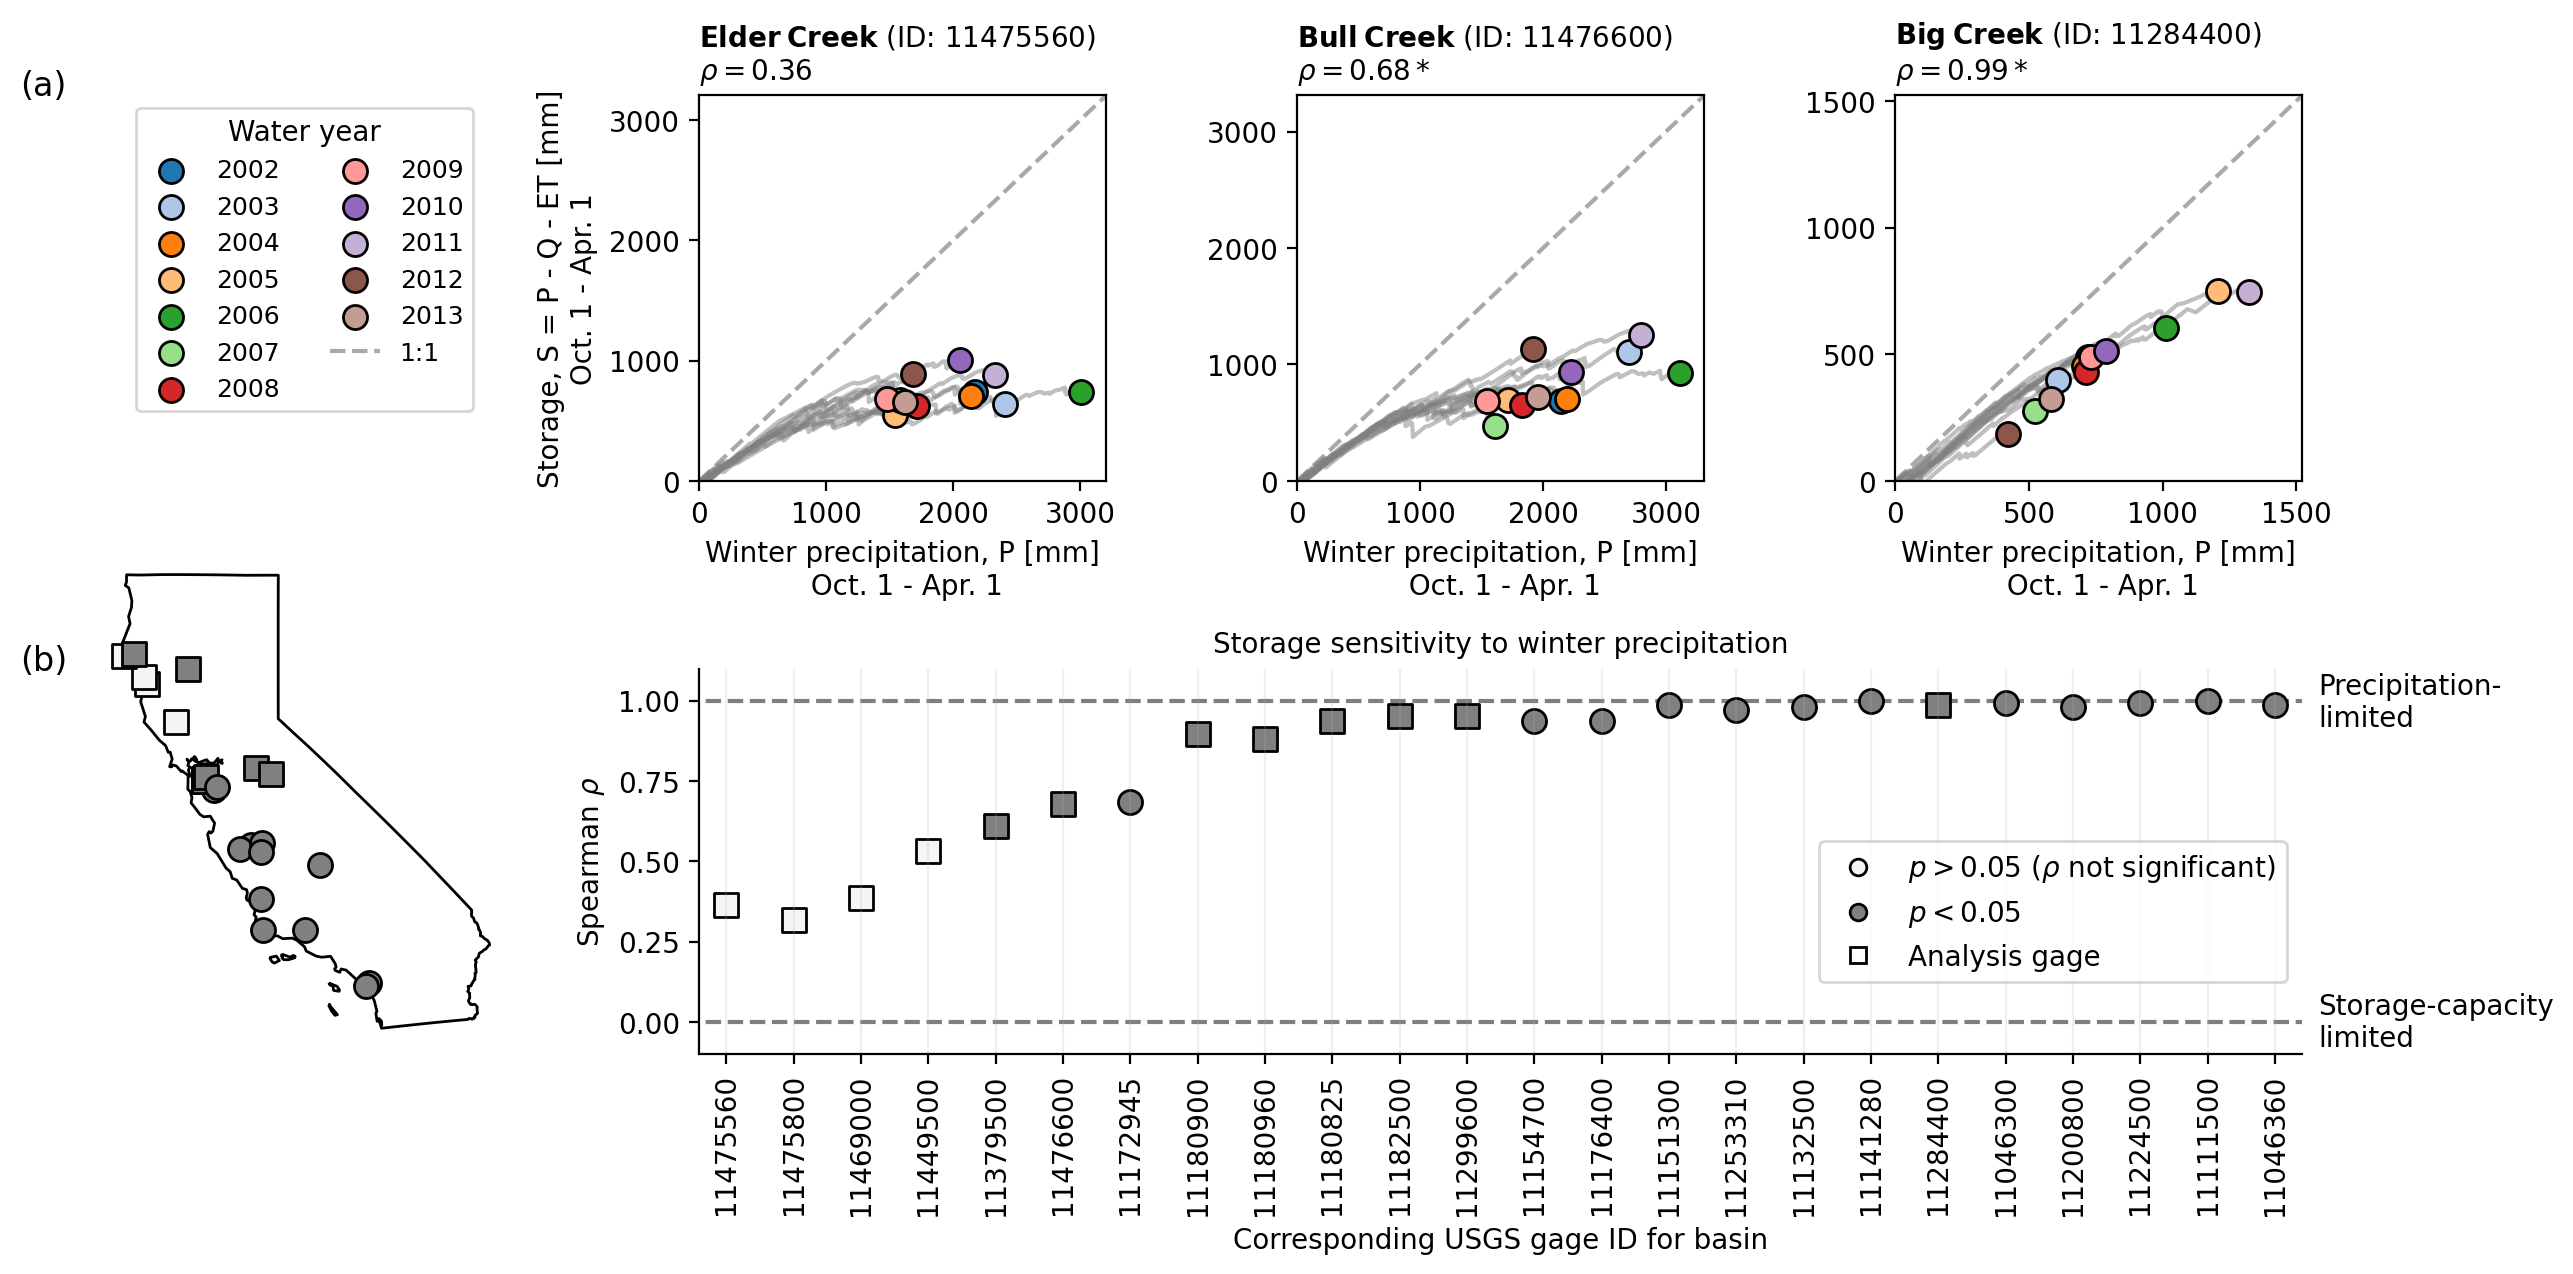

In [32]:
# Analysis gages
analysis_gages = ['11475800', '11475560', '11469000', '11449500', '11379500',
                  '11476600', '11180960', '11180900', '11180825', '11299600',
                  '11182500', '11284400']

# Figure layout, color map, select gages
fig,axs = plt.subplots(2,4,figsize=(13,6.5))
palette = sns.color_palette("tab20", len(analysis_years))
select_gages = ['11475560','11476600','11284400']

# Plot method of calculating rho at select gages
for i,gage in enumerate(select_gages):
  ax = axs[0,i+1]
  limit = np.array([])
  # Define gage data
  winter_cumsum = df_winter.groupby('wateryear').cumsum(numeric_only=True).filter(regex=".*%s"%gage).dropna()
  precip = winter_cumsum["ppt_%s"%gage]
  storage = winter_cumsum["ppt_%s"%gage] - winter_cumsum["et_%s"%gage] - winter_cumsum["q_%s"%gage]
  for j,year in enumerate(analysis_years):
    precip_wy = precip.loc['10-01-'+str(year-1):'03-30-'+str(year)]
    storage_wy = storage.loc['10-01-'+str(year-1):'03-30-'+str(year)]
    if len(precip_wy) == 0: continue
    ax.plot(precip_wy,storage_wy,c='grey',alpha=0.5)
    ax.scatter(precip_wy[-1],storage_wy[-1],color=palette[j],edgecolor='k',zorder=10,s=75,label=str(year))
    limit = np.append(limit,precip_wy[-1])
  # 1:1 Line
  ax.set(xlim=[0,max(limit)+200],ylim=[0,max(limit)+200])
  xmin,xmax = ax.get_xlim()
  ymin,ymax = ax.get_ylim()
  ax.plot([xmin,xmax],[xmin,xmax], label="1:1", color='darkgray', ls='--', zorder=-2)
  ax.set(xlim=[xmin,xmax], ylim=[ymin,ymax])
  # Axis label
  ax.set(xlabel="Winter precipitation, P [mm]\n Oct. 1 - Apr. 1")

# Coefficient combined subplot
gs = axs[1,1].get_gridspec()
for ax in axs[1,1:]:
  ax.remove()
ax_coeff = fig.add_subplot(gs[1,1:])

# Plot correlation coefficeint at each gage
ax_coeff.set_title('Storage sensitivity to winter precipitation',fontsize=10)
ax_coeff.plot([-100,100],[1,1],'--k',alpha=0.5, zorder=1)
ax_coeff.plot([-100,100],[0,0],'--k',alpha=0.5, zorder=1)
ax_coeff.set(xlim=[-0.4,len(gage_list)-1+0.4],ylim=[-0.1,1.1],xlabel='Corresponding USGS gage ID for basin',ylabel=r'Spearman $\rho$')
ax_coeff.set_xticks(range(len(gage_list)))
ax_coeff.set_xticklabels([gage for gage in gage_list],rotation=90)
ax_coeff.grid(axis='x',alpha=0.2)
for i, gage in enumerate(gage_list):
  m = 's' if gage in analysis_gages else 'o'
  rho = coeff.loc[gage,'rho']
  c = 'whitesmoke' if coeff.loc[gage,'p']>0.05 else 'grey'
  ax_coeff.scatter(i,rho,s=75,c=c,ec='k',marker=m)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0],[0],markerfacecolor='whitesmoke',markeredgecolor='k',marker='o',ls='',label=r'$p>0.05$ ($\rho$ not significant)'),
                   Line2D([0],[0],markerfacecolor='grey',markeredgecolor='k',marker='o',ls='',label=r'$p<0.05$'),
                   Line2D([0],[0],markerfacecolor='white',markeredgecolor='k',marker='s',ls='',label="Analysis gage")]
ax_coeff.legend(handles=legend_elements,fontsize=10,bbox_to_anchor=[0.69,0.15])
ax_coeff.annotate('Precipitation-\nlimited', (1.01,0.85), xycoords= 'axes fraction')
ax_coeff.annotate('Storage-capacity\nlimited', (1.01,0.02), xycoords= 'axes fraction')

# Map of California combined subplot
gs = axs[0,0].get_gridspec()
for ax in axs[0:,0]:
  ax.remove()
ax_cal = fig.add_subplot(gs[0:,0])

# Plot location of gages
mapsize=40
ca_shp = geemap.ee_to_gdf(ee.FeatureCollection("users/daviddralle/ca_et/CA"))
for gage in gage_list:
  m = 's' if gage in analysis_gages else 'o'
  p = coeff.loc[gage,'p']
  x = df_attributes.loc[gage,'Gage longitude']
  y = df_attributes.loc[gage,'Gage latitude']
  c = 'whitesmoke' if coeff.loc[gage,'p']>0.05 else 'grey'
  ax_cal.scatter(x,y,marker=m,c=c,ec='k',linewidth=1., s=75)
ax_cal.axis('off')
ca_shp.plot(color='white',edgecolor='k',zorder=-100,ax=ax_cal,aspect=None)
ax_cal.set_ylim(32,52)

# Custom legend
h, l = axs[0,1].get_legend_handles_labels()
ax_cal.legend(h,l,ncol=2,fontsize=9,loc='upper center',title='Water year')
ax_cal.axis('off')

# Figure title, labelling
axs[0,1].set_ylabel("Storage, S = P - Q - ET [mm]\nOct. 1 - Apr. 1")
axs[0,1].set_title(r"$\bf{Elder\hspace{0.25}Creek}$"+" (ID: 11475560)\n"+r"$\rho=%.2f$"%coeff.loc['11475560','rho'], loc='left', fontsize=10)
axs[0,2].set_title(r"$\bf{Bull\hspace{0.25}Creek}$"+" (ID: 11476600)\n"+r"$\rho=%.2f*$"%coeff.loc['11476600','rho'], loc='left', fontsize=10)
axs[0,3].set_title(r"$\bf{Big\hspace{0.25}Creek}$"+" (ID: 11284400)\n"+r"$\rho=%.2f*$"%coeff.loc['11284400','rho'], loc='left', fontsize=10)

# Annotations
ax_cal.annotate('(a)', (-.2,1), xycoords= 'axes fraction', fontsize=12)
ax_cal.annotate('(b)', (-.2,.4), xycoords= 'axes fraction', fontsize=12)

# Figure layout
fig.tight_layout()
sns.despine(ax=ax_coeff)
sns.reset_orig()

**Save completed catchment attributes table to Google Drive.** Select file name, type, and location in Drive.

In [30]:
path = "/content/drive/My Drive/recharge_deficit/" # change path here
filename = 'catchment_attributes.csv'  # change filename here
check_path_write(df_attributes,filename,path)

# **References**

Daly, C., Halbleib, M., Smith, J.I., Gibson, W.P., Doggett, M.K., Taylor, G.H., Curtis, J., and Pasteris, P.A. 2008. Physiographically-sensitive mapping of temperature and precipitation across the conterminous United States. International Journal of Climatology, 28: 2031-2064

Daly, C., J.I. Smith, and K.V. Olson. 2015. Mapping atmospheric moisture climatologies across the conterminous United States. PloS ONE 10(10):e0141140. https://doi:10.1371/journal.pone.0141140.

Dewitz, J., and U.S. Geological Survey, 2021, National Land Cover Database (NLCD) 2019 Products (ver. 2.0, June 2021): U.S. Geological Survey data release, doi:10.5066/P9KZCM54

Dralle, D. N., Hahm, W. J., Rempe, D. M., Karst, N., Anderegg, L. D. L., Thompson, S. E., Dawson, T. E., & Dietrich, W. E. (2020). Plants as sensors: Vegetation response to rainfall predicts root-zone water storage capacity in Mediterranean-type climates. Environmental Research Letters, 15(10), 104074. https://doi.org/10.1088/1748-9326/abb10b

Dralle, D. N., Hahm, W. J., Rempe, D. M., Karst, N. J., Thompson, S. E., & Dietrich, W. E. (2018). Quantification of the seasonal hillslope water storage that does not drive streamflow. Hydrological processes, 32(13), 1978-1992.  https://doi.org/10.1002/hyp.11627

Gan, R., Zhang, Y.Q., Shi, H., Yang, Y.T., Eamus, D., Cheng, L., Chiew, F.H.S., Yu, Q., 2018. Use of satellite leaf area index estimating evapotranspiration and gross assimilation for Australian ecosystems. Ecohydrology, https://doi:10.1002/eco.1974

Hahm, W. J., Dralle, D. N., Rempe, D. M., Bryk, A. B., Thompson, S. E., Dawson, T. E., & Dietrich, W. E. (2019). Low Subsurface Water Storage Capacity Relative to Annual Rainfall Decouples Mediterranean Plant Productivity and Water Use From Rainfall Variability. Geophysical Research Letters, 46(12), 6544–6553. https://doi.org/10.1029/2019GL083294

Kirchner, J. W. (2009). Catchments as simple dynamical systems: Catchment characterization, rainfall-runoff modeling, and doing hydrology backward. Water Resources Research, 45(2). https://doi.org/10.1029/2008WR006912

McCormick, E. L., Dralle, D. N., Hahm, W. J., Tune, A. K., Schmidt, L. M., Chadwick, K. D., & Rempe, D. M. (2021). Widespread woody plant use of water stored in bedrock. Nature, 597(7875), Article 7875. https://doi.org/10.1038/s41586-021-03761-3

Palmroth, S., Katul, G. G., Hui, D., McCarthy, H. R., Jackson, R. B., & Oren, R. (2010). Estimation of long‐term basin scale evapotranspiration from streamflow time series. Water Resources Research, 46(10). https://doi.org/10.1029/2009WR008838

Rupp, D. E., & Selker, J. S. (2006). Information, artifacts, and noise in dQ/dt− Q recession analysis. Advances in water resources, 29(2), 154-160.  https://doi.org/10.1016/j.advwatres.2005.03.019

Sauer, V. B. (2002). Standards for the analysis and processing of surface-water data and information using electronic methods (Tech. Rep.). US Geological Survey.

Soil Survey Staff: Gridded National Soil Survey Geographic (gNATSGO) Database for the Conterminous United States, Tech. rep., United States Department of Agriculture, Natural Resources Conservation Service, available online at /https://nrcs.app.box.com/v/soils, 2019.

Wang-Erlandsson, L., Bastiaanssen, W. G. M., Gao, H., Jägermeyr, J., Senay, G. B., van Dijk, A. I. J. M., Guerschman, J. P., Keys, P. W., Gordon, L. J., & Savenije, H. H. G. (2016). Global root zone storage capacity from satellite-based evaporation. Hydrology and Earth System Sciences, 20(4), 1459–1481. https://doi.org/10.5194/hess-20-1459-2016

Wlostowski, A. N., Molotch, N.,Anderson, S. P., Brantley, S. L.,Chorover, J., Dralle, D., et al. (2021).Signatures of hydrologic functionacross the Critical Zone Observatorynetwork.Water Resources Research,57,e2019WR026635. https://doi.org/10.1029/2019WR026635

Zhang, Y., Peña-Arancibia, J.L., McVicar, T.R., Chiew, F.H.S., Vaze, J., Liu, C., Lu, X., Zheng, H., Wang, Y., Liu, Y.Y., Miralles, D.G., Pan, M., 2016. Multi-decadal trends in global terrestrial evapotranspiration and its components. Sci. Rep. 6, 19124. https://doi:10.1038/srep19124

Zhang, Y., Kong, D., Gan, R., Chiew, F.H.S., McVicar, T.R., Zhang, Q., and Yang, Y., 2019. Coupled estimation of 500m and 8-day resolution global evapotranspiration and gross primary production in 2002-2017. Remote Sens. Environ. 222, 165-182, https://doi:10.1016/j.rse.2018.12.031